In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import h5py
import sklearn.linear_model


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Problem Statement: You have just been hired as an AI expert by the French Football Corporation. 
They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head.They give you the following 2D dataset from France's past 10 games.

In [7]:
#First, lets define some helper functions for the Model we will develop

def sigmoid(x):
 
    s = 1/(1+np.exp(-x))
    return s

def relu(x):

    s = np.maximum(0,x)
    
    return s

def load_planar_dataset(seed):
    
    np.random.seed(seed)
    
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def initialize_parameters(layer_dims):

    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def forward_propagation(X, parameters):
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def backward_propagation(X, Y, cache):

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate):

    n = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def compute_cost(a3, Y):

    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost


def predict_dec(parameters, X):

    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

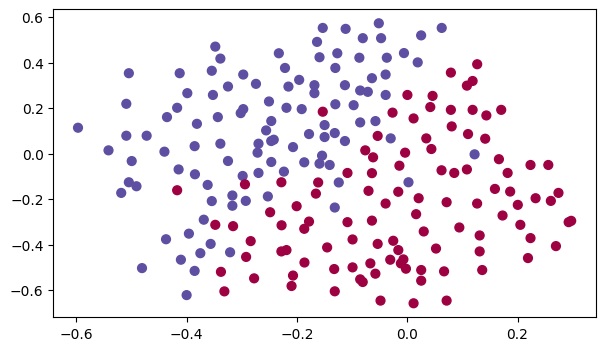

In [4]:
# Now lets begin by Loading the dataset
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.

If the dot is blue, it means the French player managed to hit the ball with his/her head
If the dot is red, it means the other team's player hit the ball with their head
Your goal: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

We will first try a non-regularized model. Then we'll learn how to regularize it and decide which model we will choose to solve the French Football Corporation's problem.

In [5]:
#Define the Model
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):

    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]

    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)

        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)

        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   # it is possible to use both L2 regularization and dropout,
                                                # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572417
Cost after iteration 20000: 0.13851642423261248


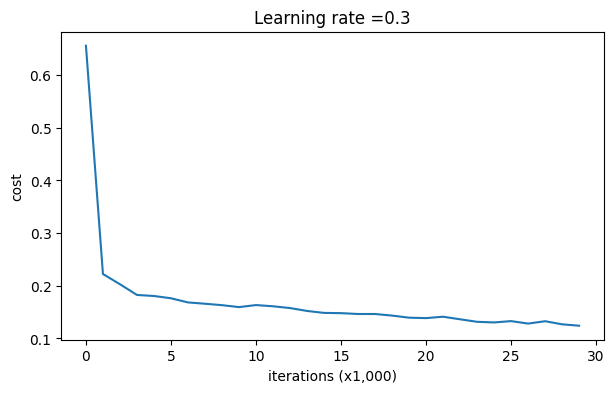

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [8]:
#lets train the un-regularized model and observe result
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. 
This is the baseline model (you will observe the impact of regularization on this model).

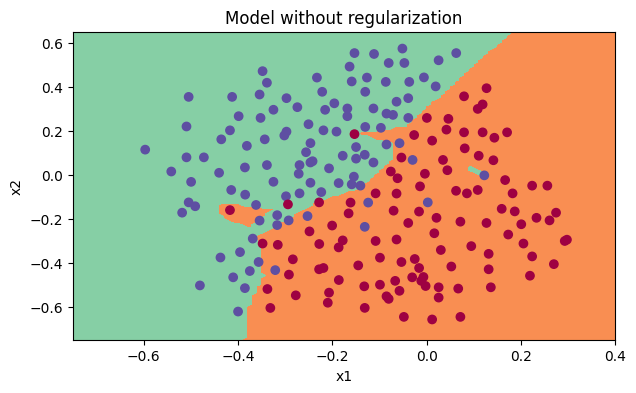

In [9]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set.
It is even fitting the noisy points! Lets now look at two techniques to reduce overfitting.

#L2 Regularization 
The standard way to avoid overfitting is called L2 regularization

In [10]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """

    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model

    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost


    L2_regularization_cost = (lambd / (2 * m)) * (
        np.sum(np.square(W1)) +
        np.sum(np.square(W2)) +
        np.sum(np.square(W3))
    )


    cost = cross_entropy_cost + L2_regularization_cost

    return cost

In [13]:
np.random.seed(1)
Y = np.array([[1, 1, 0, 1, 0]])
W1 = np.random.randn(2, 3)
b1 = np.random.randn(2, 1)
W2 = np.random.randn(3, 2)
b2 = np.random.randn(3, 1)
W3 = np.random.randn(1, 3)
b3 = np.random.randn(1, 1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
A3 = np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]])
lambd = 0.1
cost = compute_cost_with_regularization(A3, Y, parameters, lambd=0.1)
print("cost = " + str(cost))


cost = 1.7864859451590758


In [15]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, 
                 activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    

    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd / m) * W3
    
    
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    
    
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd / m) * W2
    
    
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
   
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd / m) * W1
    
    
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1,
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [17]:
np.random.seed(1)
X = np.random.randn(3, 5)
Y = np.array([[1, 1, 0, 1, 0]])
cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
         [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
np.array([[ 0.        ,  3.32524635,  2.13994541,  2.60700654,  0.        ],
         [ 0.        ,  4.1600994 ,  0.79051021,  1.46493512,  0.        ]]),
np.array([[-1.09989127, -0.17242821, -0.87785842],
         [ 0.04221375,  0.58281521, -1.10061918]]),
np.array([[ 1.14472371],
         [ 0.90159072]]),
np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [-0.69166075, -3.47645987, -2.25194702, -2.65416996, -0.69166075],
         [-0.39675353, -4.62285846, -2.61101729, -3.22874921, -0.39675353]]),
np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
np.array([[ 0.50249434,  0.90085595],
         [-0.68372786, -0.12289023],
         [-0.93576943, -0.26788808]]),
np.array([[ 0.53035547],
         [-0.69166075],
         [-0.39675353]]),
np.array([[-0.3771104 , -4.10060224, -1.60539468, -2.18416951, -0.3771104 ]]),
np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]]),
np.array([[-0.6871727 , -0.84520564, -0.67124613]]),
np.array([[-0.0126646]]))
lambd = 0.7

grads = backward_propagation_with_regularization(X, Y, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282238
Cost after iteration 20000: 0.26809163371273004


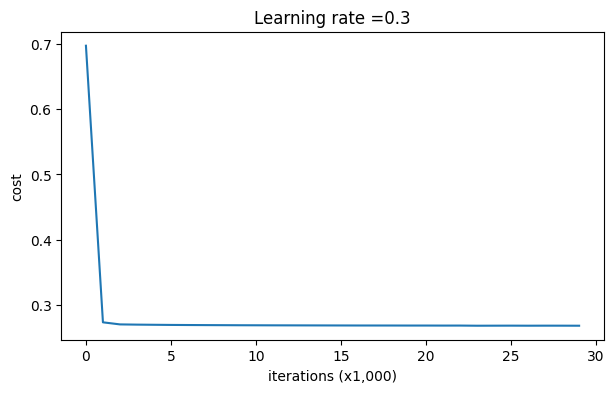

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [18]:
#Let's now run the model with L2 regularization  (𝜆=0.7)
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The test set accuracy increased to 93%. We have saved the French football team!
We are not overfitting the training data anymore. Let's plot the decision boundary.

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.



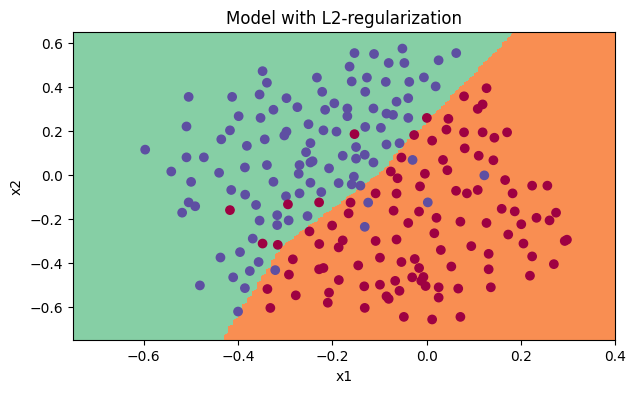

In [19]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Now, lets try dropout regularization. 

dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration.
Let's say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them. We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.

Set  𝐴[1] to  𝐴[1]∗𝐷[1] . (You are shutting down some neurons). You can think of  𝐷[1] as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
Then Divide  𝐴[1] by keep_prob. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [21]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> DROPOUT
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    
    # Step 1: initialize matrix D1 (same shape as A1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # random numbers between 0 and 1
    
    # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as threshold)
    D1 = (D1 < keep_prob).astype(int)                 # or: D1 = np.random.rand(...) < keep_prob
    
    # Step 3: shut down some neurons of A1
    A1 = A1 * D1                                      # element-wise multiplication
    
    # Step 4: scale the value of neurons that haven't been shut down
    A1 = A1 / keep_prob                               # inverted dropout scaling
    
    
    # LINEAR -> RELU -> DROPOUT
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    
    # Step 1: initialize matrix D2 (same shape as A2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    
    # Step 2: convert entries of D2 to 0 or 1
    D2 = (D2 < keep_prob).astype(int)
    
    # Step 3: shut down some neurons of A2
    A2 = A2 * D2
    
    # Step 4: scale the remaining values
    A2 = A2 / keep_prob
    
    
    # LINEAR -> SIGMOID (no dropout on the output layer)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [22]:
np.random.seed(1)
X = np.random.randn(3, 5)
W1 = np.random.randn(2, 3)
b1 = np.random.randn(2, 1)
W2 = np.random.randn(3, 2)
b2 = np.random.randn(3, 1)
W3 = np.random.randn(1, 3)
b3 = np.random.randn(1, 1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

A3 = np.array([[0.36974721, 0.00305176, 0.04565099, 0.49683389, 0.36974721]])
cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
        [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
 np.array([[ True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True]]),
 np.array([[0.        , 0.        , 3.05706487, 3.72429505, 0.        ],
        [0.        , 5.94299915, 1.1293003 , 2.09276446, 0.        ]]),
 np.array([[-1.09989127, -0.17242821, -0.87785842],
        [ 0.04221375,  0.58281521, -1.10061918]]),
 np.array([[1.14472371],
        [0.90159072]]),
 np.array([[ 0.53035547,  5.88414161,  3.08385015,  4.28707196,  0.53035547],
        [-0.69166075, -1.42199726, -2.92064114, -3.49524533, -0.69166075],
        [-0.39675353, -1.98881216, -3.55998747, -4.44246165, -0.39675353]]),
 np.array([[ True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True],
        [False, False,  True,  True, False]]),
 np.array([[0.75765067, 8.40591658, 4.40550021, 0.        , 0.75765067],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 np.array([[ 0.50249434,  0.90085595],
        [-0.68372786, -0.12289023],
        [-0.93576943, -0.26788808]]),
 np.array([[ 0.53035547],
        [-0.69166075],
        [-0.39675353]]),
 np.array([[-0.53330145, -5.78898099, -3.04000407, -0.0126646 , -0.53330145]]),
 np.array([[0.36974721, 0.00305176, 0.04565099, 0.49683389, 0.36974721]]),
 np.array([[-0.6871727 , -0.84520564, -0.67124613]]),
 np.array([[-0.0126646]]))
keep_prob = 0.7

A3, cache = forward_propagation_with_dropout(X, parameters, keep_prob=0.7)
print ("A3 = " + str(A3))


A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


In [23]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
 
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    
    
    # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 * D2
    
    # Step 2: Scale the value of neurons that haven't been shut down
    dA2 = dA2 / keep_prob
   
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    
   
    # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 * D1
    
    # Step 2: Scale the value of neurons that haven't been shut down
    dA1 = dA1 / keep_prob
    
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1,
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [24]:
np.random.seed(1)
X = np.random.randn(3, 5)
Y = np.array([[1, 1, 0, 1, 0]])
cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
           [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]), np.array([[ True, False,  True,  True,  True],
           [ True,  True,  True,  True, False]], dtype=bool), np.array([[ 0.        ,  0.        ,  4.27989081,  5.21401307,  0.        ],
           [ 0.        ,  8.32019881,  1.58102041,  2.92987024,  0.        ]]), np.array([[-1.09989127, -0.17242821, -0.87785842],
           [ 0.04221375,  0.58281521, -1.10061918]]), np.array([[ 1.14472371],
           [ 0.90159072]]), np.array([[ 0.53035547,  8.02565606,  4.10524802,  5.78975856,  0.53035547],
           [-0.69166075, -1.71413186, -3.81223329, -4.61667916, -0.69166075],
           [-0.39675353, -2.62563561, -4.82528105, -6.0607449 , -0.39675353]]), np.array([[ True, False,  True, False,  True],
           [False,  True, False,  True,  True],
           [False, False,  True, False, False]], dtype=bool), np.array([[ 1.06071093,  0.        ,  8.21049603,  0.        ,  1.06071093],
           [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]), np.array([[ 0.50249434,  0.90085595],
           [-0.68372786, -0.12289023],
           [-0.93576943, -0.26788808]]), np.array([[ 0.53035547],
           [-0.69166075],
           [-0.39675353]]), np.array([[-0.7415562 , -0.0126646 , -5.65469333, -0.0126646 , -0.7415562 ]]), np.array([[ 0.32266394,  0.49683389,  0.00348883,  0.49683389,  0.32266394]]), np.array([[-0.6871727 , -0.84520564, -0.67124613]]), np.array([[-0.0126646]]))
keep_prob = 0.8

gradients = backward_propagation_with_dropout(X, Y, cache, keep_prob=0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.6543912405149825


/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_75364/2282538094.py:139: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_75364/2282538094.py:139: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.060582435798513114


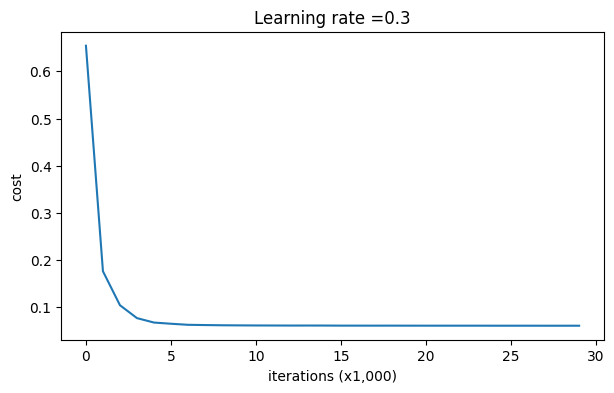

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [25]:
#Time to train and run the model
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)!
Our model is not overfitting the training set and does a great job on the test set.
The French football team will be forever grateful to us!

Lets see the decision boundary


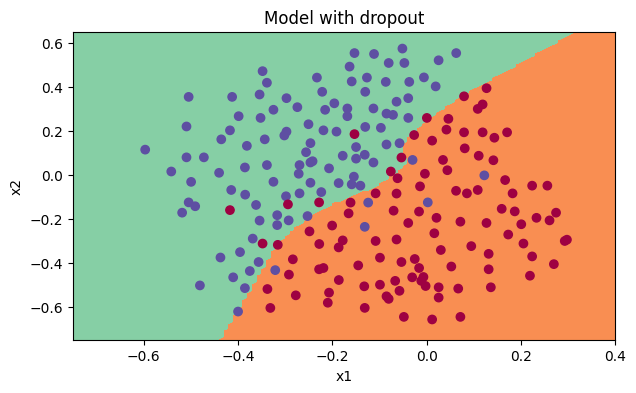

In [26]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

What you should remember about dropout:

Dropout is a regularization technique.
You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
Apply dropout both during forward and backward propagation.
During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations.
For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since 
only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now 
has the same expected value. You can check that this works even when keep_prob is other values than 0.5.